In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from os import cpu_count
from math import floor
import pandas as pd
import numpy as np

In [3]:
datasets={}
for dirname, _, filenames in os.walk('/project_ghent/raman/netflow_datasets'):
    for filename in filenames:
        if filename.endswith("parquet"):
            datasets[filename.replace(".parquet","")]=pd.read_parquet(os.path.join(dirname, filename))

In [4]:
for k,v in datasets.items():
    print(k)
    print(v.Attack.unique())
    v["dataset"]=k

NF-ToN-IoT-V2
['ransomware' 'Benign' 'xss' 'scanning' 'password' 'dos' 'ddos'
 'injection' 'mitm' 'backdoor']
NF-UNSW-NB15-V2
['Benign' 'Exploits' 'Generic' 'Fuzzers' 'Backdoor' 'DoS' 'Reconnaissance'
 'Shellcode' 'Worms' 'Analysis']
NF-BoT-IoT-V2
['DoS' 'DDoS' 'Reconnaissance' 'Benign' 'Theft']
NF-CSE-CIC-IDS2018-V2
['SSH-Bruteforce' 'Benign' 'DDoS attacks-LOIC-HTTP' 'DDOS attack-HOIC'
 'DoS attacks-Slowloris' 'DoS attacks-Hulk' 'FTP-BruteForce'
 'Infilteration' 'Bot' 'DoS attacks-GoldenEye' 'Brute Force -Web'
 'DoS attacks-SlowHTTPTest' 'SQL Injection' 'DDOS attack-LOIC-UDP'
 'Brute Force -XSS']


In [5]:
for ds,data in datasets.items():
    ddos=data[data['Attack'].str.contains("ddos",case=False)]
    ddos.Attack="DDoS"#uniform name
    dos=data[data['Attack'].str.contains("dos",case=False)]
    dos.Attack="DoS"#uniform name
    dos.drop(index=ddos.index,inplace=True)
    benign=data[data['Attack'] == 'Benign']
    data = pd.concat(objs=[ddos, dos, benign])
    
    # random forest classifier works internally with float32 so values too big will give errors
    data = data[data['SRC_TO_DST_SECOND_BYTES'] <= np.finfo(np.float32).max]
    data = data[data['DST_TO_SRC_SECOND_BYTES'] <= np.finfo(np.float32).max]
    
    data=data.drop(columns=['L4_SRC_PORT', 'L4_DST_PORT']) # dropping metadata

    
    datasets[ds]=data

/tmp/ipykernel_1313/3237961987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddos.Attack="DDoS"#uniform name
/tmp/ipykernel_1313/3237961987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dos.Attack="DoS"#uniform name
/tmp/ipykernel_1313/3237961987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dos.drop(index

In [6]:
for k,v in datasets.items():
    print(k)
    print(v.Attack.value_counts())

NF-ToN-IoT-V2
Attack
Benign    3601194
DDoS      1746590
DoS        654359
Name: count, dtype: int64
NF-UNSW-NB15-V2
Attack
Benign    1911666
DoS          4172
Name: count, dtype: int64
NF-BoT-IoT-V2
Attack
DDoS      14280259
DoS       13645057
Benign      129437
Name: count, dtype: int64
NF-CSE-CIC-IDS2018-V2
Attack
Benign    15101526
DDoS       1276019
DoS         483999
Name: count, dtype: int64


In [7]:
import matplotlib.pyplot as plt

In [10]:
data=pd.concat(datasets.values())
data.loc[data.Attack=="Benign","dataset"]="Benign"
data.dataset.unique()

In [15]:
data_ddos=data[(data.Attack=="DDoS")|(data.Attack=="Benign")]
data_dos=data[(data.Attack=="DoS")|(data.Attack=="Benign")]

feature_generalization=["FTP_COMMAND_RET_CODE","DNS_TTL_ANSWER", "DNS_QUERY_TYPE", "DNS_QUERY_ID", "RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","NUM_PKTS_1024_TO_1514_BYTES","RETRANSMITTED_IN_PKTS","NUM_PKTS_512_TO_1024_BYTES"]


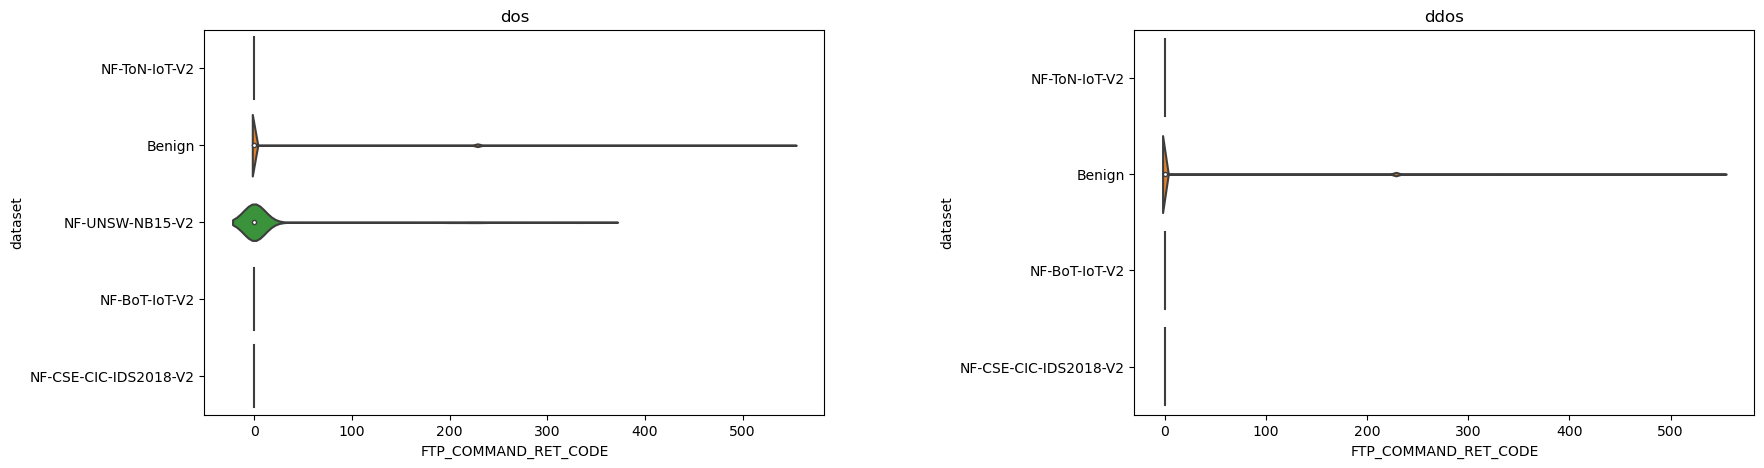

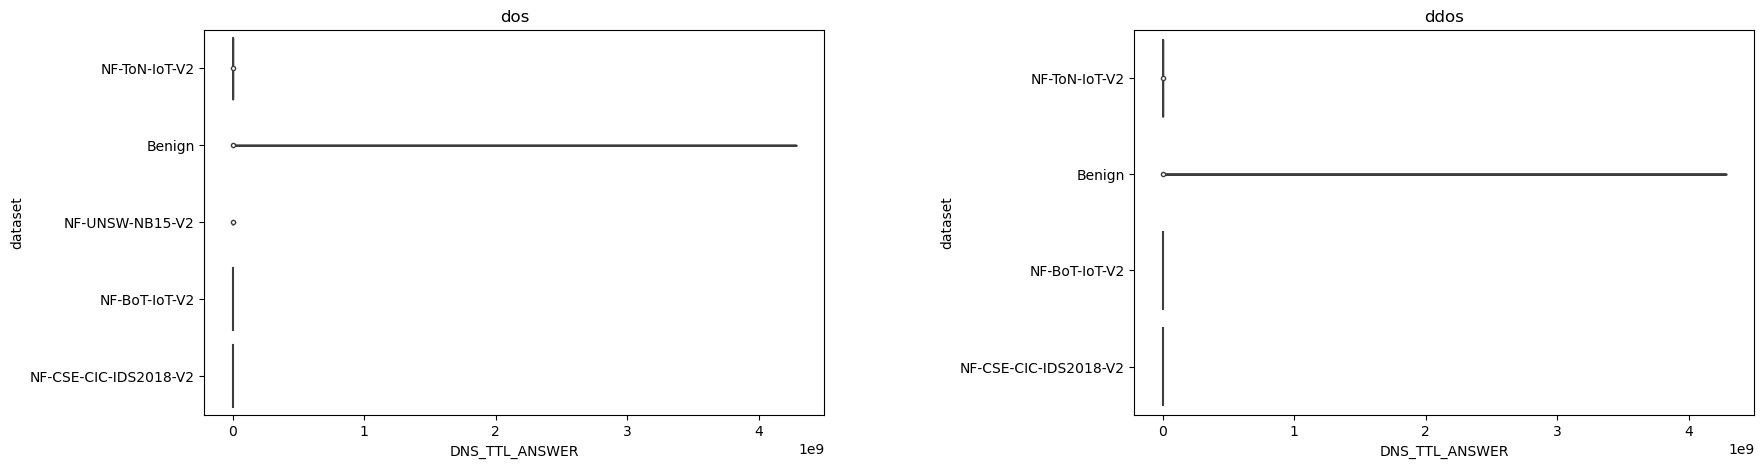

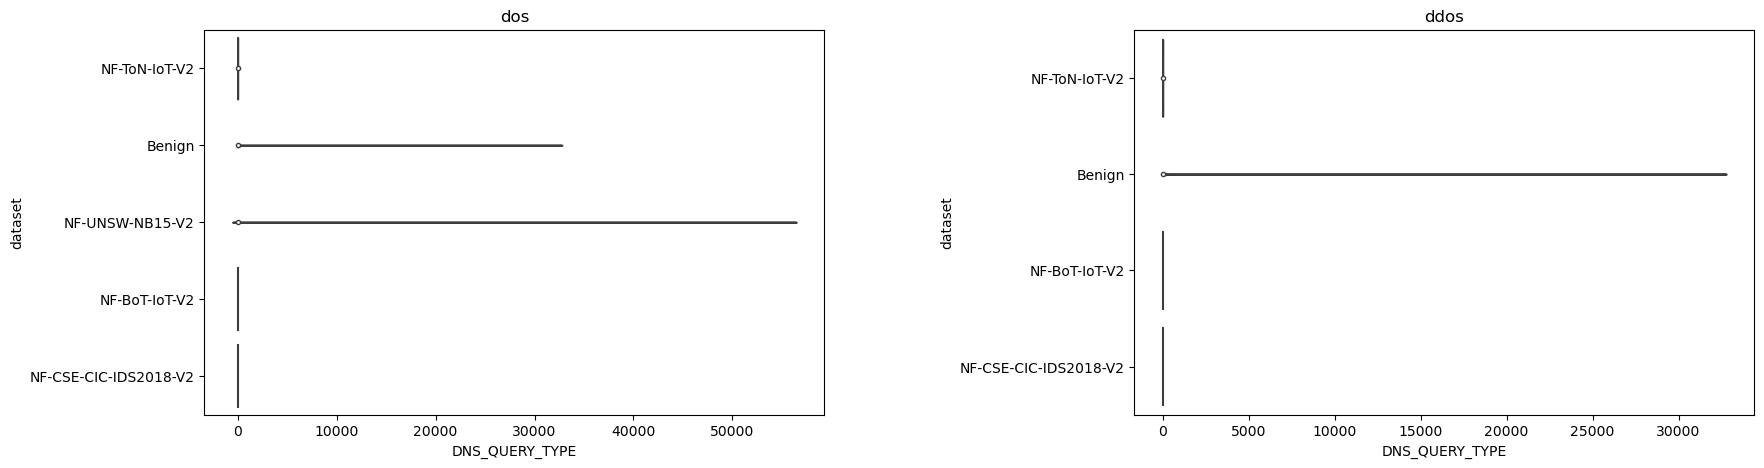

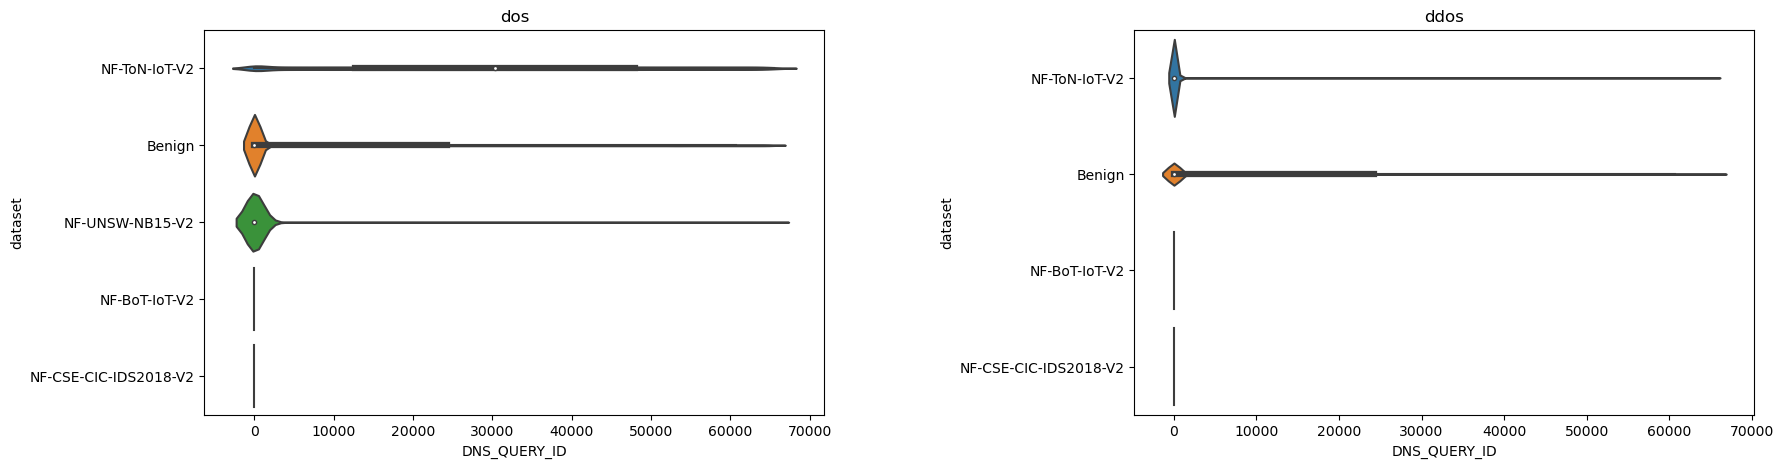

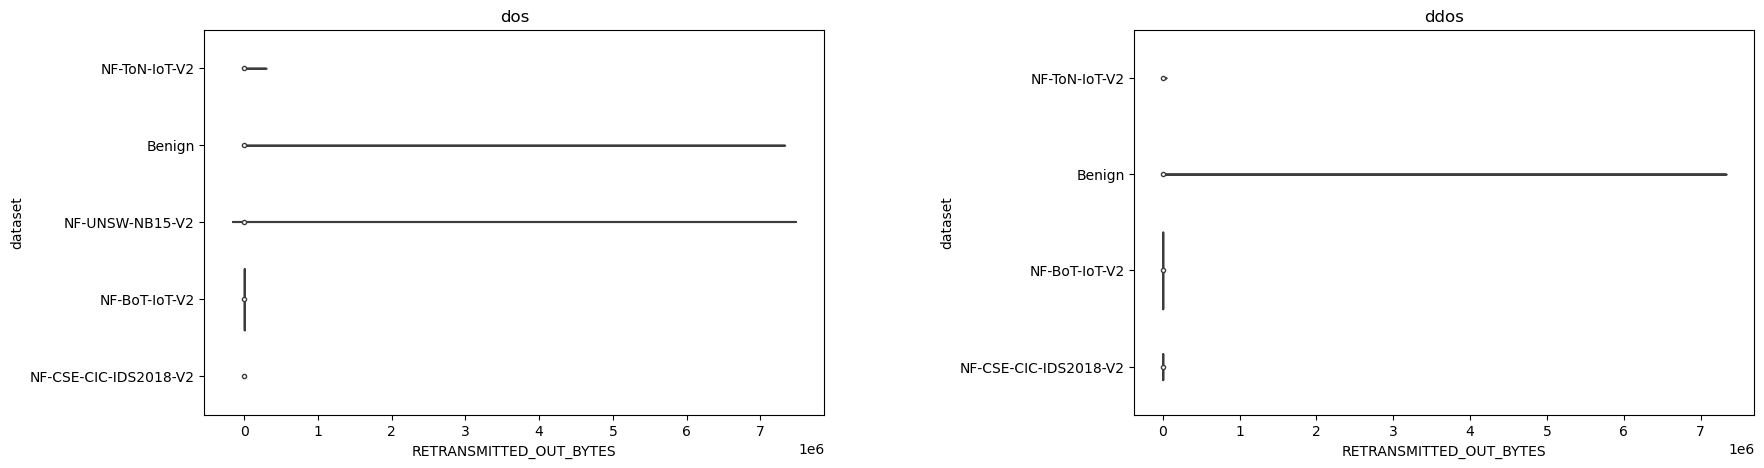

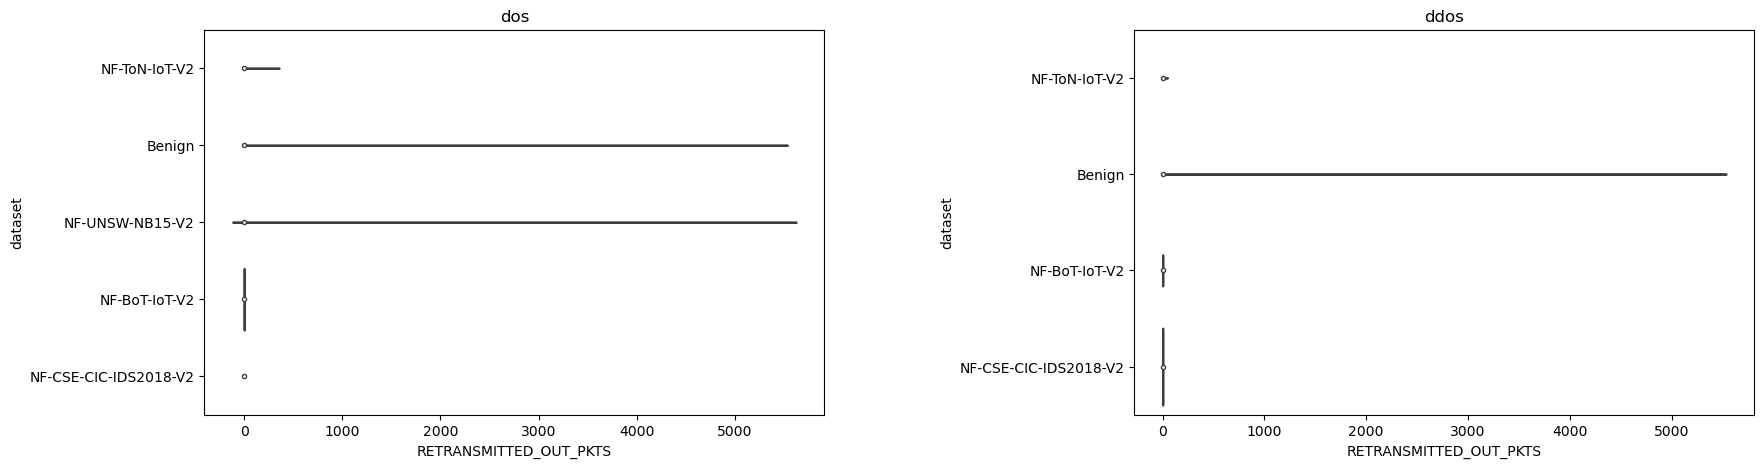

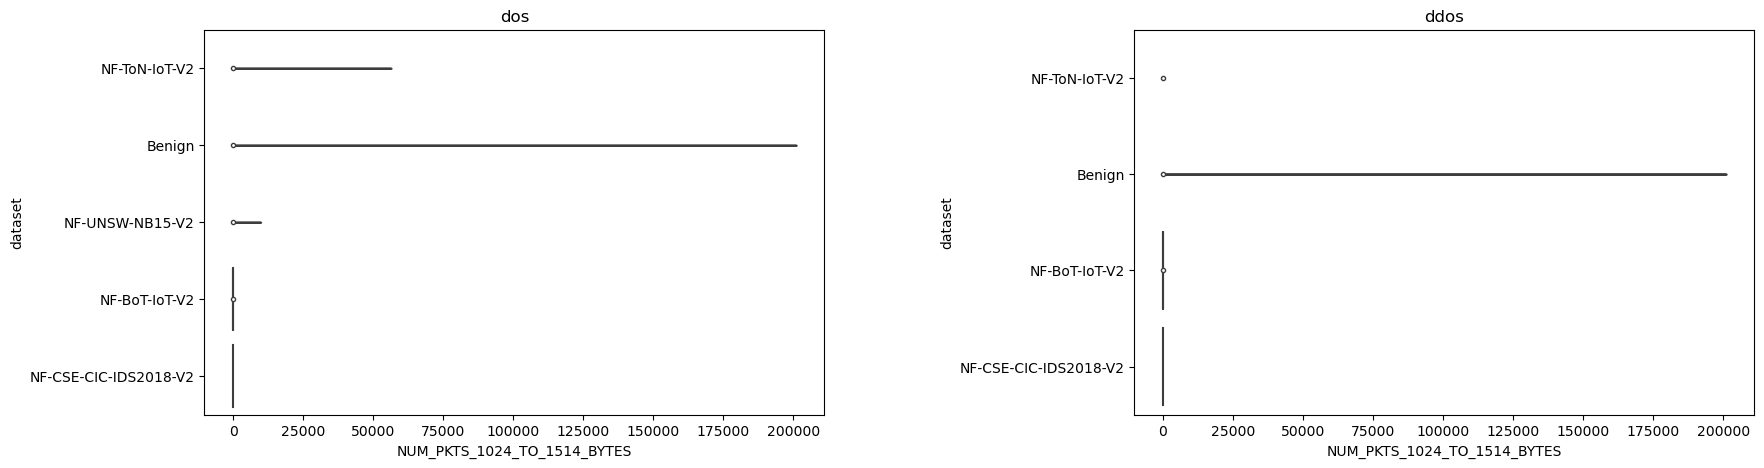

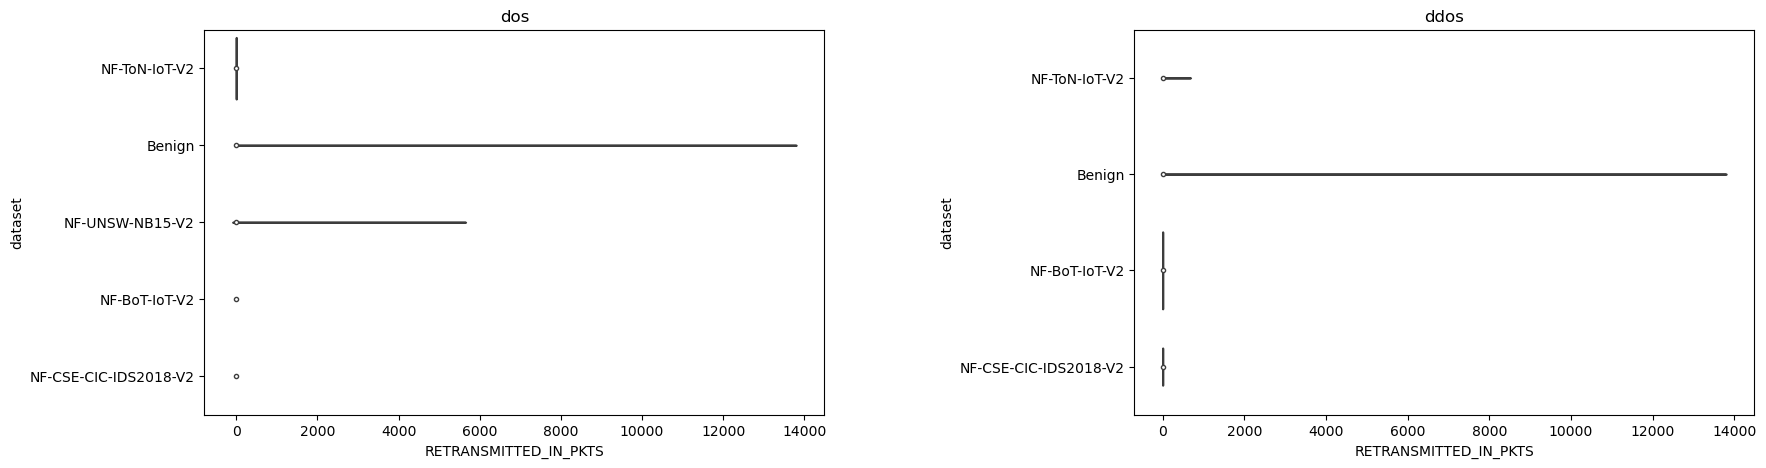

In [14]:
import seaborn as sns

for feature in feature_generalization:
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

    # Plot the DoS violin plot on the first subplot
    sns.violinplot(data=data_dos, x=feature, y="dataset", ax=ax1)

    # Set the title for the first subplot
    ax1.set_title(f"dos")

    # Plot the DDoS violin plot on the second subplot
    sns.violinplot(data=data_ddos, x=feature, y="dataset", ax=ax2)

    # Set the title for the second subplot
    ax2.set_title(f"ddos")

    # Adjust spacing between subplots to prevent label overlap
    plt.subplots_adjust(wspace=0.5)

    # Display the plot
    plt.show()
    fig.savefig(f"./plots/violin/{feature}.png")


In [19]:
datasets=data_dos.dataset.unique()

In [27]:
feature_generalization=["FTP_COMMAND_RET_CODE","DNS_TTL_ANSWER", "DNS_QUERY_TYPE", "DNS_QUERY_ID", "RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","NUM_PKTS_1024_TO_1514_BYTES","RETRANSMITTED_IN_PKTS","NUM_PKTS_512_TO_1024_BYTES"]
for f in feature_generalization:
    for ds in datasets:
        print((data_dos[data_dos.dataset==ds][f]==0).mean())

1.0
0.9828569208289137
0.9391179290508149
1.0
1.0
0.8634969489225334
0.6143015200235752
0.9928092042186002
1.0
1.0
0.06867789699538021
0.6031695314793227
0.9793863854266539
1.0
1.0
0.06869470733954909
0.6031683745084019
0.9714765100671141
1.0
1.0
0.9999510971805996
0.8934638036585638
0.45589645254074784
0.9999764017108906
0.7788941712689489
0.9999510971805996
0.8934638036585638
0.45589645254074784
0.9999764017108906
0.7788941712689489
0.9996194749365409
0.7167394361203333
0.7023010546500479
0.999355224386384
1.0
0.9999923589344687
0.8691547840530649
0.24952061361457334
0.6726980327015124
0.626629393862384
0.9996851881001102
0.7405726514345982
0.7090124640460211
0.9997268607965507
0.04823150461054672


In [26]:
(data_dos.FTP_COMMAND_RET_CODE==0).mean()

0.9899844391202038

In [29]:
similar_dos={}
similar_dos["NF-BoT-IoT-V2_NF-CSE-CIC-IDS2018-V2"]=["FTP_COMMAND_RET_CODE","DNS_QUERY_TYPE", "DNS_TTL_ANSWER", "DNS_QUERY_ID", "NUM_PKTS_1024_TO_1514_BYTES"]
similar_dos["NF-ToN-IoT-V2_NF-BoT-IoT-V2"]=["FTP_COMMAND_RET_CODE","RETRANSMITTED_OUT_BYTES", "RETRANSMITTED_OUT_PKTS", "NUM_PKTS_1024_TO_1514_BYTES", "NUM_PKTS_512_TO_1024_BYTES"]
similar_dos["NF-ToN-IoT-V2_NF-CSE-CIC-IDS2018-V2"]= ["FTP_COMMAND_RET_CODE", "NUM_PKTS_1024_TO_1514_BYTES"]
similar_dos["NF-UNSW-NB15-V2_NF-BoT-IoT-V2"]=["DNS_TTL_ANSWER", "DNS_QUERY_TYPE"]
similar_dos["NF-UNSW-NB15-V2_NF-CSE-CIC-IDS2018-V2"]=["DNS_TTL_ANSWER", "DNS_QUERY_TYPE"]

similar_ddos={}
similar_ddos["NF-BoT-IoT-V2_NF-CSE-CIC-IDS2018-V2"]=["FTP_COMMAND_RET_CODE","DNS_QUERY_TYPE", "DNS_TTL_ANSWER", "DNS_QUERY_ID","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","RETRANSMITTED_IN_PKTS", "NUM_PKTS_1024_TO_1514_BYTES"]
similar_ddos["NF-ToN-IoT-V2_NF-CSE-CIC-IDS2018-V2	"]=["FTP_COMMAND_RET_CODE"]
similar_ddos["NF-ToN-IoT-V2_NF-BoT-IoT-V2"]=["FTP_COMMAND_RET_CODE"]

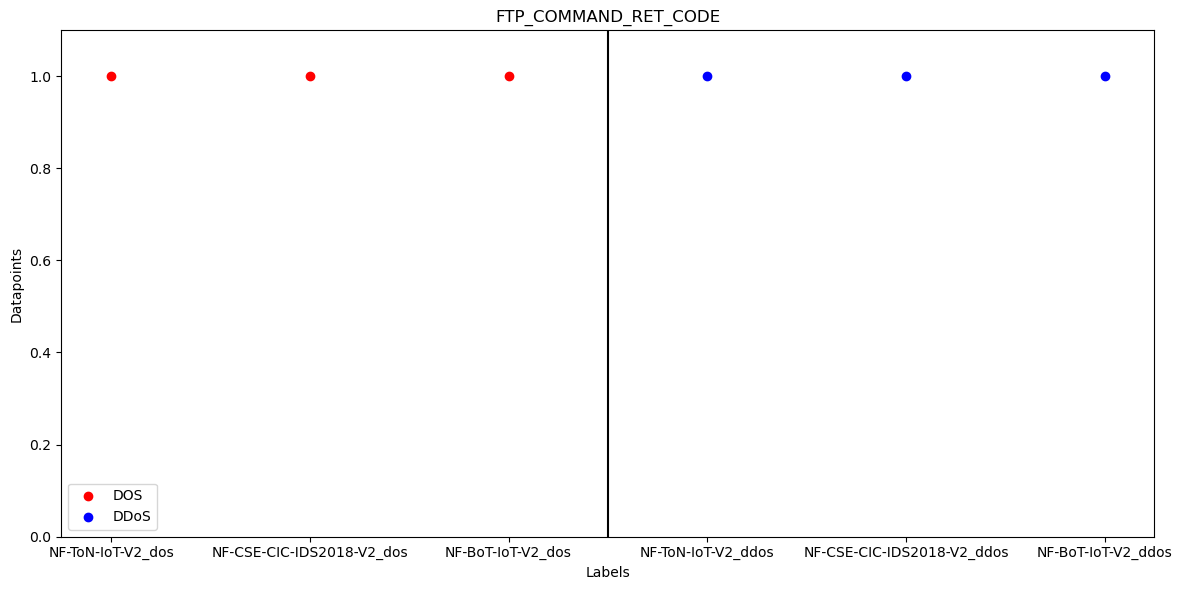

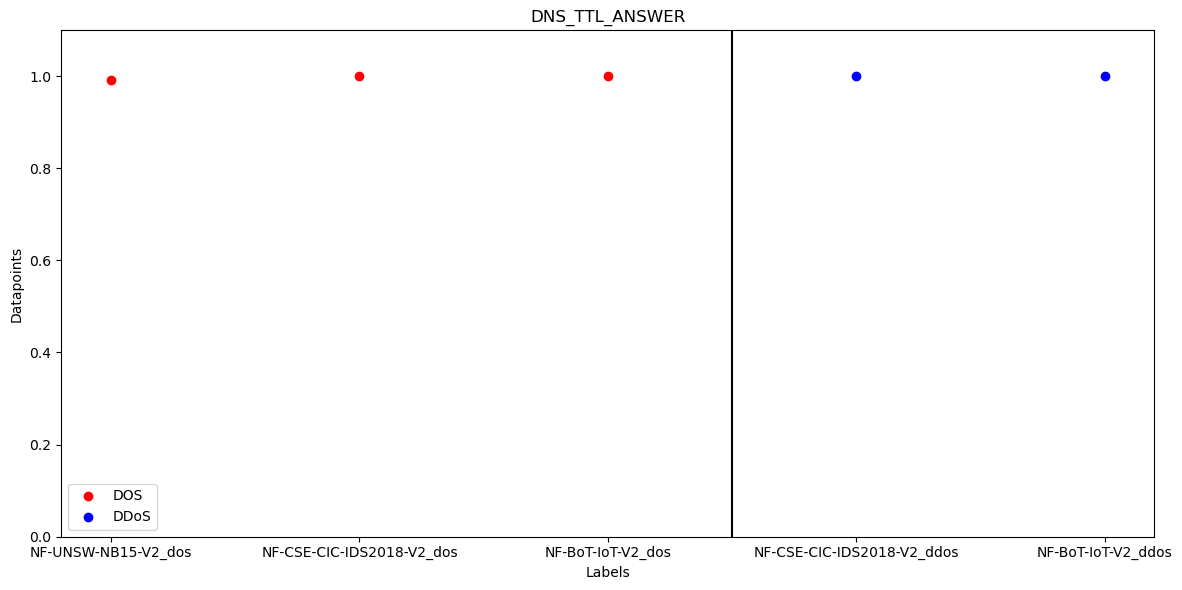

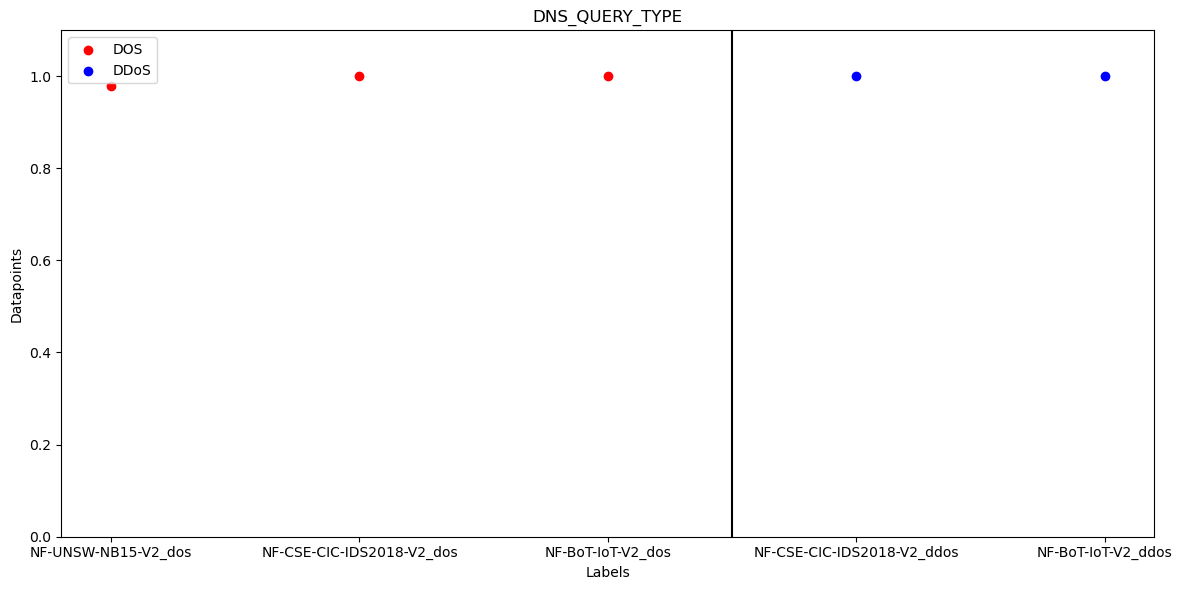

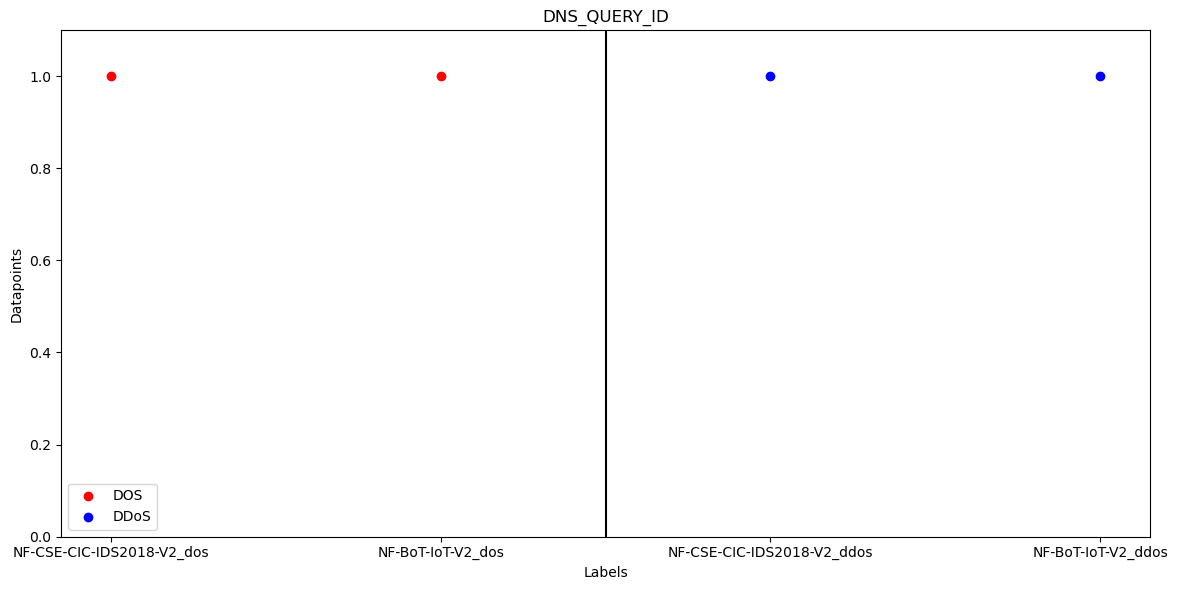

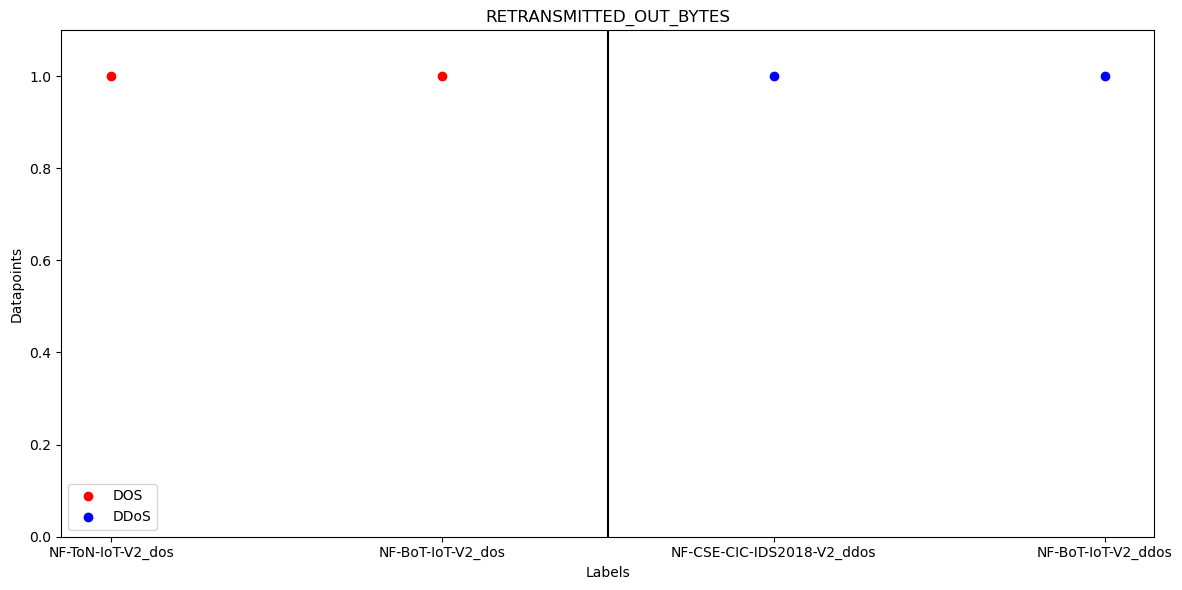

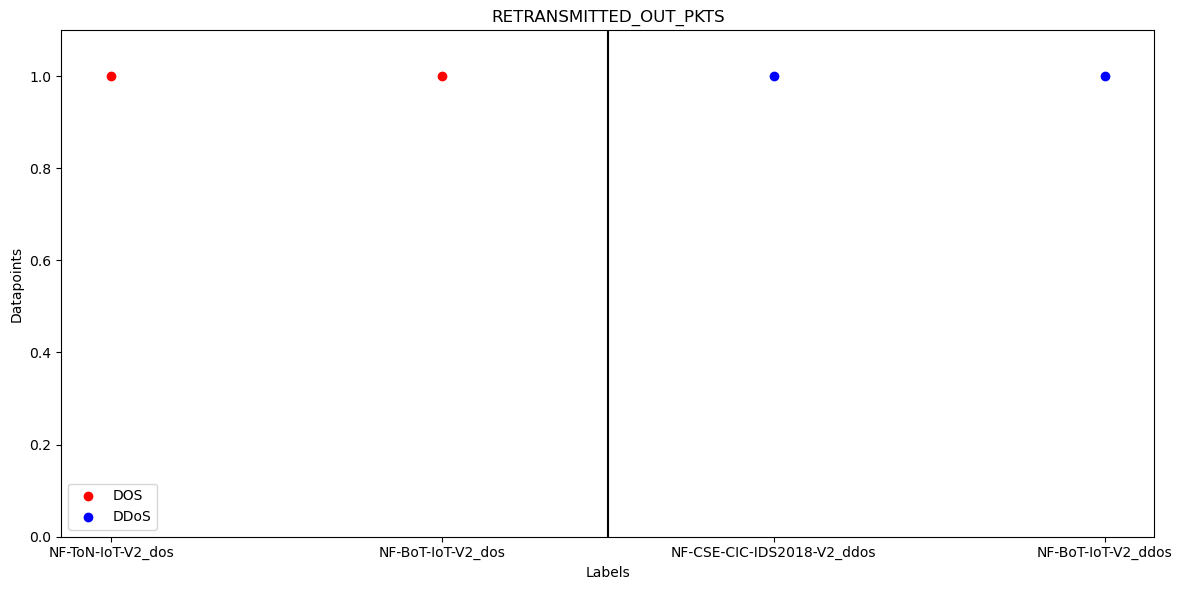

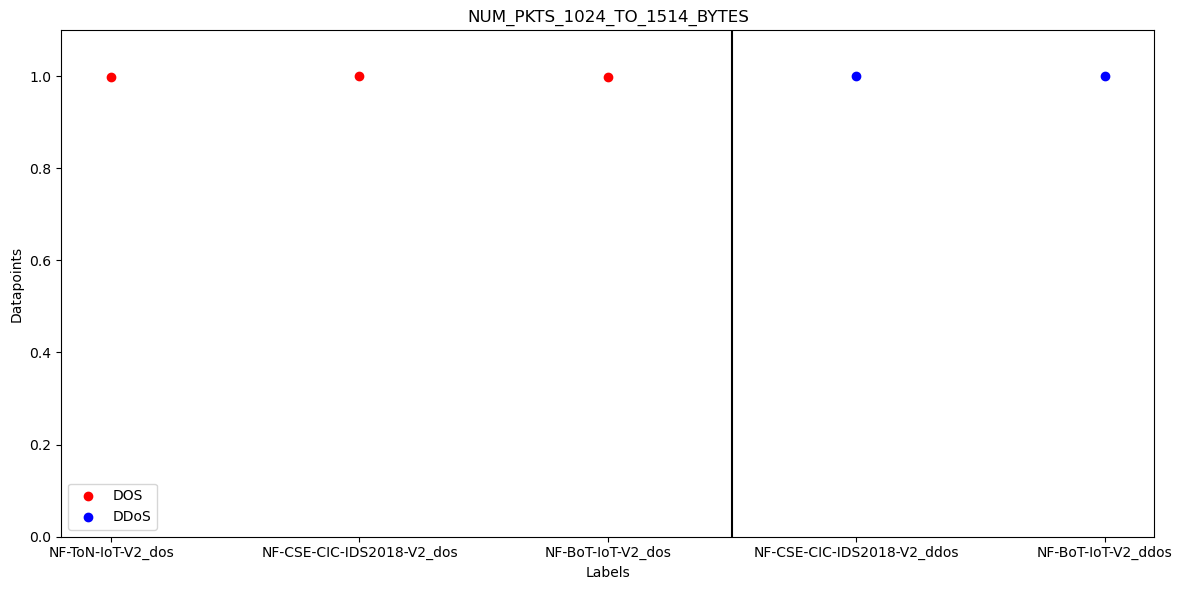

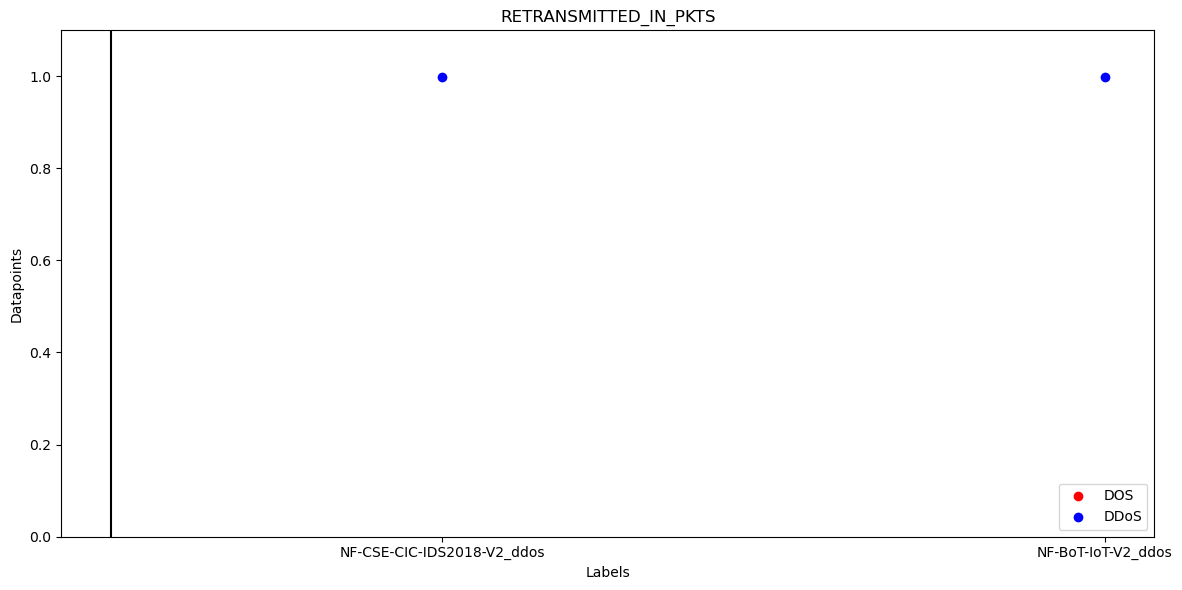

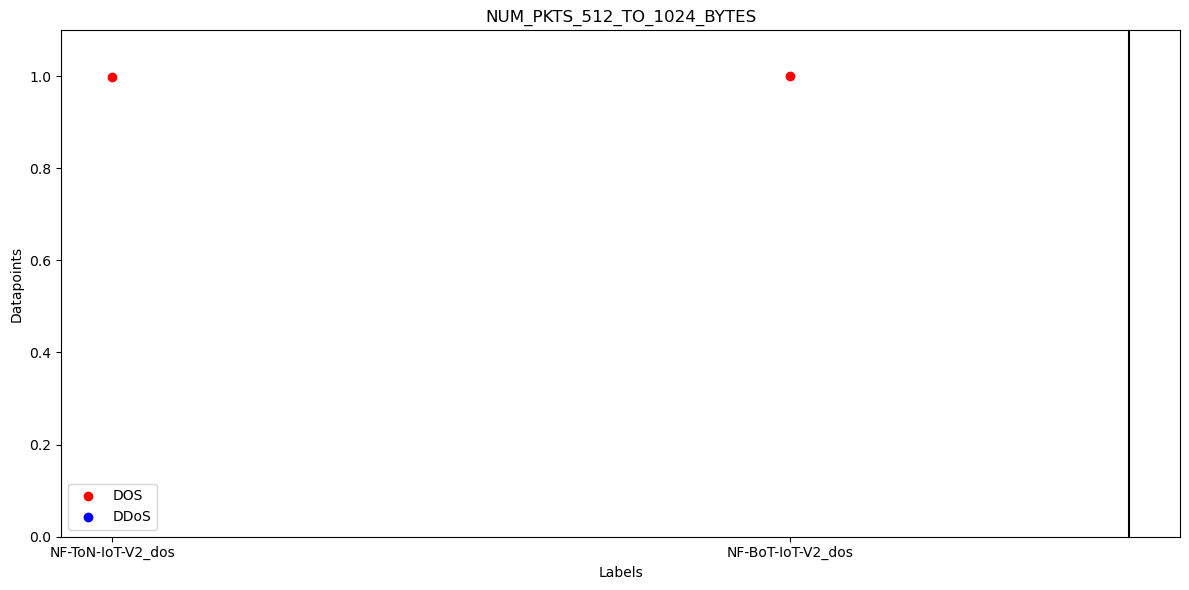

In [97]:
for f in feature_generalization:
    values_dos=[]
    values_ddos=[]
    for k,v in similar_dos.items():
        if f in v:
            values_dos.append(k)
    for k,v in similar_ddos.items():
        if f in v:
            values_ddos.append(k)
    #for each feature we now have 
    
    # Data for DOS
    labels_dos = list(set([element for x in values_dos for element in x.strip().split("_")]))
    datapoints_dos = []
    for d in labels_dos:
        datapoints_dos.append((data_dos[data_dos.dataset==d][f]==0).mean())
    # Data for DDoS
    labels_ddos = list(set([element for x in values_ddos for element in x.strip().split("_")]))

    datapoints_ddos=[]
    for d in labels_ddos:
        datapoints_ddos.append((data_ddos[data_ddos.dataset==d][f]==0).mean())
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot DOS data
    ax.scatter([x+"_dos" for x in labels_dos], datapoints_dos, color='red', label='DOS')

    # Add a vertical line
    ax.axvline(x=len(labels_dos) - 0.5, color='black')

    # Plot DDoS data
    ax.scatter([x+"_ddos" for x in labels_ddos], datapoints_ddos, color='blue', label='DDoS')

    # Set axis labels and title
    ax.set_xlabel('Labels')
    ax.set_ylabel('Datapoints')
    ax.set_title(f)

    # Set y-axis limits
    ax.set_ylim(0, 1.1)
    
    # Add legend
    ax.legend()
    fig.tight_layout()


    # Show the plot
    plt.show()
    fig.savefig(f"./plots/scatter/{f}.png")


In [93]:
datapoints_ddos

[0.9999945141882683, 0.9999184888733461]

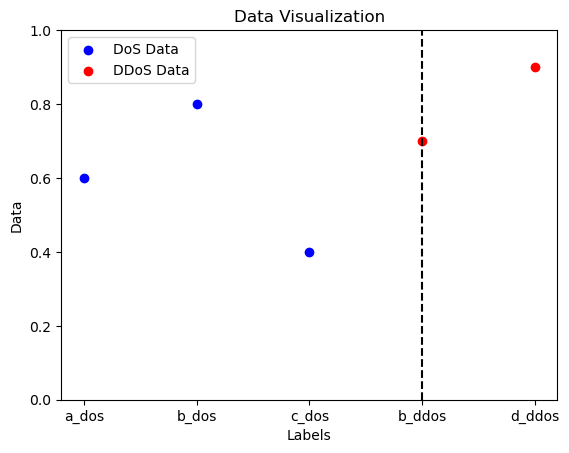

In [42]:
import matplotlib.pyplot as plt

# Data
dos_labels = ['a_dos', 'b_dos', 'c_dos']
ddos_labels = ['b_ddos', 'd_ddos']
dos_data = [0.6, 0.8, 0.4]
ddos_data = [0.7, 0.9]

# Plot settings
dos_color = 'blue'
ddos_color = 'red'
vertical_line_color = 'black'

# Plotting
plt.scatter(range(len(dos_labels)), dos_data, color=dos_color, label='DoS Data')
plt.scatter(range(len(dos_labels), len(dos_labels) + len(ddos_labels)), ddos_data, color=ddos_color, label='DDoS Data')
plt.axvline(len(dos_labels), color=vertical_line_color, linestyle='--')

# Customize plot
plt.xticks(range(len(dos_labels) + len(ddos_labels)), dos_labels + ddos_labels)
plt.ylim(0, 1)
plt.xlabel('Labels')
plt.ylabel('Data')
plt.title('Data Visualization')

# Add legend
plt.legend()

# Show plot
plt.show()


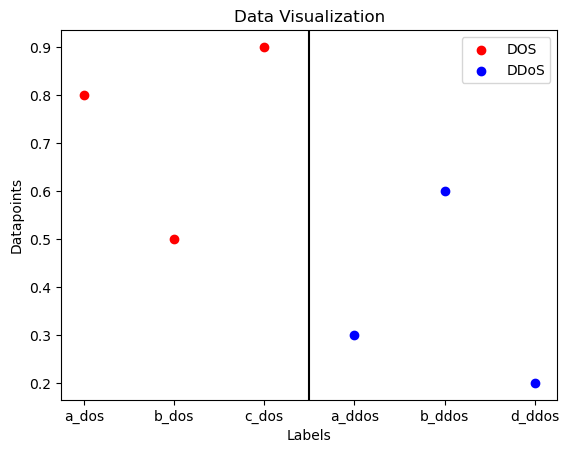

In [56]:
import matplotlib.pyplot as plt

# Data for DOS
labels_dos = ['a_dos', 'b_dos', 'c_dos']
datapoints_dos = [0.8, 0.5, 0.9]

# Data for DDoS
labels_ddos = ['a_ddos', 'b_ddos', 'd_ddos']
datapoints_ddos = [0.3, 0.6, 0.2]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot DOS data
ax.scatter(labels_dos, datapoints_dos, color='red', label='DOS')

# Add a vertical line
ax.axvline(x=len(labels_dos) - 0.5, color='black')

# Plot DDoS data
ax.scatter(labels_ddos, datapoints_ddos, color='blue', label='DDoS')

# Set axis labels and title
ax.set_xlabel('Labels')
ax.set_ylabel('Datapoints')
ax.set_title('Data Visualization')

# Add legend
ax.legend()

# Show the plot
plt.show()
